In [27]:
# IMPORTS

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import ast
from matplotlib.animation import FuncAnimation, PillowWriter
from geopy import distance

plt.ioff()

In [28]:
# # IMPORT DATA

# directory = '.\Data'
# all_files = os.listdir(directory)
# csv_files = [f for f in all_files if f.startswith('CAMP') and f.endswith('csv')]

# data_list = []

# for file in csv_files:
#     file_path = os.path.join(directory, file)
#     df = pd.read_csv(file_path, encoding='latin-1')
#     data_list.append(df)

# data_concat = pd.concat(data_list, ignore_index=True)

# # DROP UNUSED COLUMNS
# data_concat = data_concat.drop(columns=['OBJECTID', 'NUMERO_ORDINE', 'TECNICO', 'ID', 'TIPOLOGIA'])

# # ADJUST DATE FORMAT
# data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat.DATA_RILEVAMENTO, format='mixed')

# # ADJUST SPECIES NAMES
# # Remove non-species
# data_concat = data_concat[~data_concat['SPECIE'].isin(['06', '****', 'nan']) & ~data_concat['SPECIE'].isna()]

# # Group same species under same name (replacement dictionaries are in 'Species.txt')
# with open('Species.txt', 'r') as file:
#     file_content = file.read()

# replacement_dict_list = ast.literal_eval(file_content)
# for replacement_dict in replacement_dict_list:
#     data_concat['SPECIE'] = data_concat['SPECIE'].replace(replacement_dict)

# # ADJUST CASE IN OTHER COLUMNS
# column_list = ['CULTIVAR', 'RISULTATO', 'COMUNE', 'SINTOMO']

# for column in column_list:
#     data_concat[column] = data_concat[column].str.capitalize()

# # SORT BY DATE
# data_concat = data_concat.sort_values(by='DATA_RILEVAMENTO')

# # REMOVE ROWS WITH NO COORDINATE DATA
# data_concat = data_concat.dropna(subset=['LATITUDINE', 'LONGITUDINE'])

# # REMOVE WRONG DATA
# lat_min = 39.0
# lon_max = 18.9
# mask = (data_concat['LATITUDINE'] < lat_min) & (data_concat['LONGITUDINE'] > lon_max)
# data_concat = data_concat[~mask]

# # EXPORT CLEANED DATAFRAME
# data_concat.to_csv('.\Data\Dati_monitoraggio_2013-2023.csv', index=False)


In [29]:
# IMPORT CLEANED DATAFRAME
data_concat = pd.read_csv('.\Data\Dati_monitoraggio_2013-2023.csv', low_memory=False)
data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat['DATA_RILEVAMENTO'])

In [30]:
# CREATE MAP FUNCTION
def create_map(limits, ax, resolution):
    lat_min, lat_max, lon_min, lon_max = limits
    m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2, lon_0=(lon_max-lon_min)/2,
                projection='merc', resolution=resolution, area_thresh=10000., ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='white',lake_color='#46bcec')
    return m

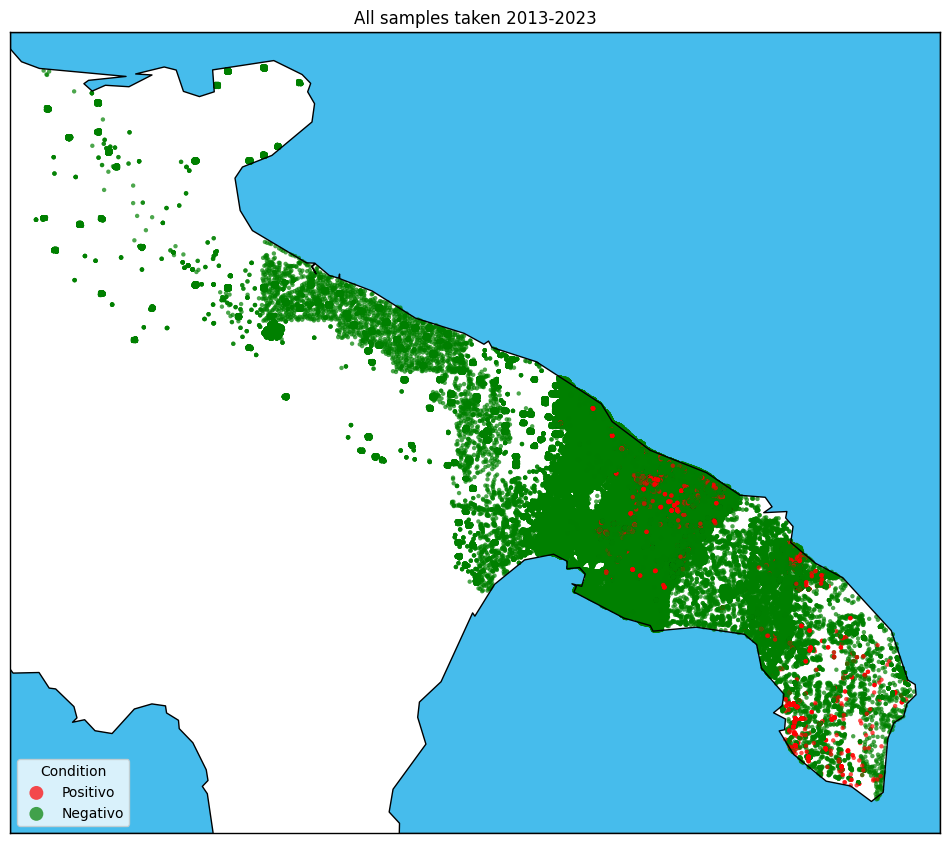

In [31]:
# Coordinate data of samples
lat = data_concat['LATITUDINE'].values
lon = data_concat['LONGITUDINE'].values

# Map margins
margin = 0.1 # buffer to add to the range
lat_min = np.min(lat) - margin
lat_max = np.max(lat) + margin
lon_min = np.min(lon) - margin
lon_max = np.max(lon) + margin
limits = [lat_min, lat_max, lon_min, lon_max]

color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_concat['COLOR'] = data_concat['RISULTATO'].map(color_map)

fig, ax = plt.subplots(figsize=(12,12))
m = create_map(limits, ax, 'i')
lons, lats = m(lon, lat)
sc = m.scatter(lons, lats, c=data_concat['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# Legend
for condition in color_map:
    ax.scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
ax.legend(title='Condition', loc='lower left')

year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
year_min = np.min(year_list)
year_max = np.max(year_list)
plt.title(f'All samples taken {year_min}-{year_max}')
plt.savefig('Images/All_samples_2013-2023.png', dpi=300)
plt.show()

In [32]:
# PLOT POSITIVE SAMPLES YEAR BY YEAR
nrows = 3
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

positives = data_concat[data_concat['RISULTATO'] == 'Positivo'].copy()

for i, year in enumerate(year_list):
    yearly_data = positives[positives['DATA_RILEVAMENTO'].dt.year == year]
    
    lat = yearly_data['LATITUDINE'].values
    lon = yearly_data['LONGITUDINE'].values
    
    row = i // ncols
    col = i % ncols

    m = create_map(limits, ax[row,col], 'i')
    lons, lats = m(lon, lat)
    sc = m.scatter(lons, lats, c=yearly_data['COLOR'].values, marker='o', s=0.5, edgecolor='none', alpha=0.7)
    ax[row,col].set_title(f'Samples {year}')

ax[-1,-1].axis('off')

fig.suptitle('Yearly positive samples', fontsize=16)
plt.savefig('Images/Positive_samples_2013-2023.png', dpi=300)
plt.close(fig)

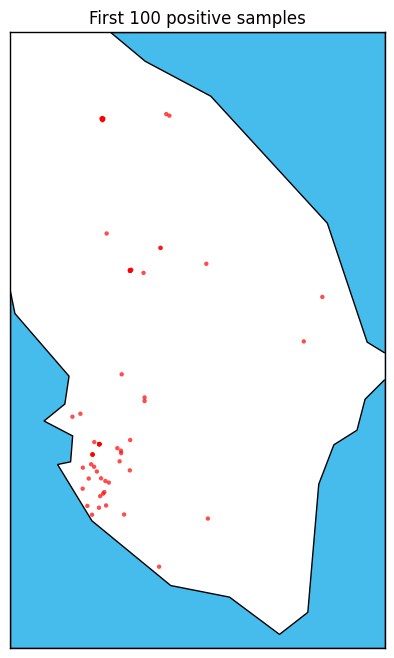

In [34]:
# PLOT FIRST N POSITIVE SAMPLES
N = 100
first_positives = positives[:N]

# Coordinate data of samples
lat = first_positives['LATITUDINE'].values
lon = first_positives['LONGITUDINE'].values

lat_min = np.min(lat) - margin
lat_max = np.max(lat) + margin
lon_min = np.min(lon) - margin
lon_max = np.max(lon) + margin
limits = [lat_min, lat_max, lon_min, lon_max]

fig, ax = plt.subplots(figsize=(8,8))
m = create_map(limits, ax, 'i')
lons, lats = m(lon, lat)
sc = m.scatter(lons, lats, c=first_positives['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

plt.title(f'First {N} positive samples')
plt.savefig(f'Images/First_{N}_Positive_samples.png', dpi=300)
plt.show()

In [35]:
# ANIMATION
fig, ax = plt.subplots(figsize=(8,8))
m = create_map(limits, ax, 'i')

# Function to update scatter plot for each frame
def update(frame):
    ax.clear()
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='white',lake_color='#46bcec')
    
    current_date = unique_dates[frame]
    current_data = first_positives[first_positives['DATA_RILEVAMENTO'] <= current_date]
    
    x, y = m(current_data['LONGITUDINE'].values, current_data['LATITUDINE'].values)
    sc = m.scatter(x, y, c=current_data['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)    
    ax.set_title(f'Test Results as of {current_date.date()}')

unique_dates = first_positives['DATA_RILEVAMENTO'].unique()
ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)
ani.save(f'Images/First_{N}_Positive_samples_evolution.gif',
          writer=PillowWriter(fps=10))
plt.close(fig)

In [37]:
# PLOT FIRST GALLIPOLI POSITIVE SAMPLES
gallipoli = positives[positives['COMUNE'] == 'Gallipoli'].copy()
# gallipoli['Year'] = gallipoli['DATA_RILEVAMENTO'].dt.year

year = 2013
first_gallipoli = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year <= year]

# Coordinate data of samples
lat = first_gallipoli['LATITUDINE'].values
lon = first_gallipoli['LONGITUDINE'].values

# Map margins
margin = 0.1 # buffer to add to the range
lat_min = np.min(lat) - margin
lat_max = np.max(lat) + margin
lon_min = np.min(lon) - margin
lon_max = np.max(lon) + margin
limits = [lat_min, lat_max, lon_min, lon_max]

fig, ax = plt.subplots(figsize=(8,8))
m = create_map(limits, ax, 'i')
lons, lats = m(lon, lat)
sc = m.scatter(lons, lats, c=first_gallipoli['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.5)

plt.title(f'{np.arange(2013, year+1)} Gallipoli positive samples')
plt.close(fig)

In [40]:
# CALCULATE EVOLUTION OF MAX DISTANCE FROM EPICENTRE OF EPIDEMIC
# Determine epicentre coordinates arbitrarily: average of first cases (2013)
first_cases = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year == 2013]
epicentre = {'lat': np.mean(first_cases['LATITUDINE']), 'lon': np.mean(first_cases['LONGITUDINE'])}
epicentre_point = (epicentre['lat'], epicentre['lon'])

# Evaluate distance from epicentre
positives['DISTANCE'] = positives.apply(lambda row: distance.distance(epicentre_point, (row['LATITUDINE'], row['LONGITUDINE'])).km, axis=1)

# Evaluate max distance evolution
dates = []
max_distances = []

max_distance_so_far = 0.0

# Iterate over rows in the DataFrame
for index, row in positives.iterrows():
    # point = (row['LATITUDINE'], row['LONGITUDINE'])
    dist = row['DISTANCE']
    
    # Update maximum distance encountered so far
    if dist > max_distance_so_far:
        max_distance_so_far = dist
        dates.append(row['DATA_RILEVAMENTO'])
        max_distances.append(max_distance_so_far)

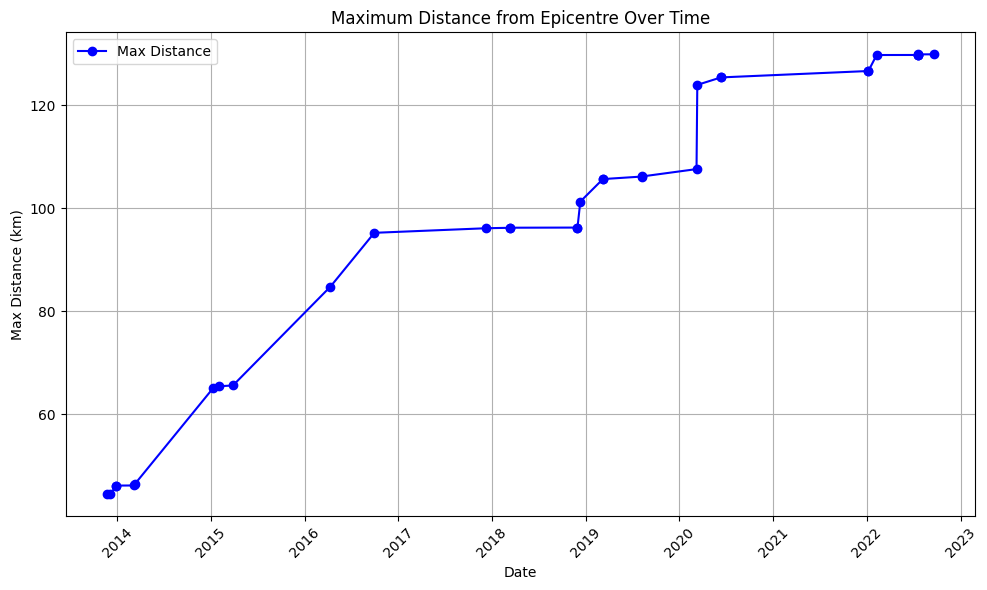

In [41]:
# PLOT DATES AND MAX DISTANCES

plt.figure(figsize=(10, 6))
plt.plot(dates, max_distances, marker='o', linestyle='-', color='b', label='Max Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Max Distance (km)')
plt.title('Maximum Distance from Epicentre Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

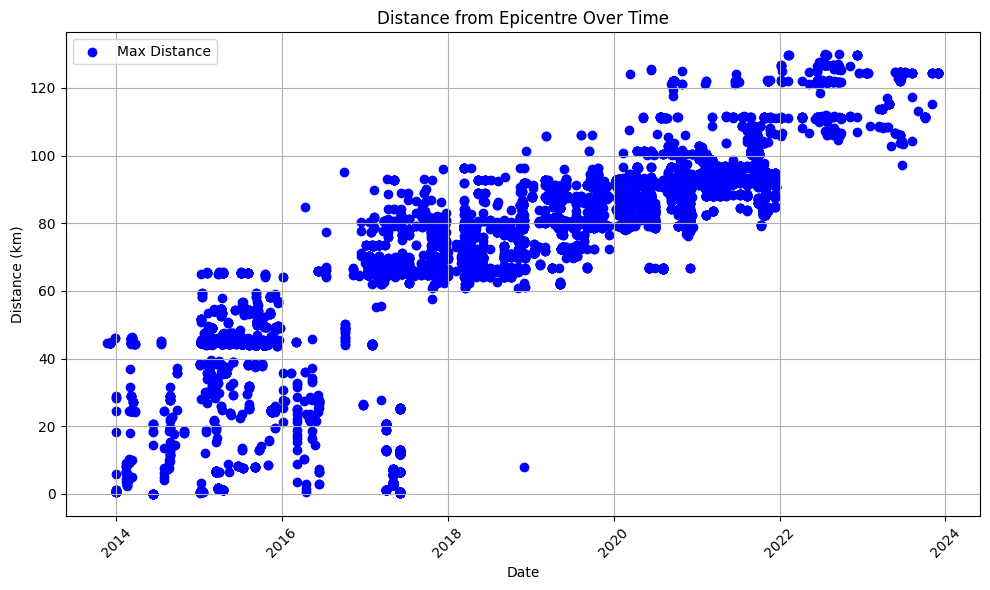

In [43]:
# PLOT ALL DISTANCES

plt.figure(figsize=(10, 6))
plt.scatter(positives['DATA_RILEVAMENTO'], positives['DISTANCE'], marker='o', linestyle='-', color='b', label='Max Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.title('Distance from Epicentre Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# CALCULATE SPEED OF DISEASE SPREAD

dates = []
max_distances = []

In [ ]:
# # Plot only positive or negatives
# positives = data_concat[data_concat['RISULTATO'] == 'Positivo']
# negatives = data_concat[data_concat['RISULTATO'] == 'Negativo']

# lat_pos = positives['LATITUDINE'].values
# lon_pos = positives['LONGITUDINE'].values
# lat_neg = negatives['LATITUDINE'].values
# lon_neg = negatives['LONGITUDINE'].values

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# # create map using BASEMAP
# m1 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[0]
#             )

# m1.drawcoastlines()
# m1.drawcountries()
# m1.drawstates()
# m1.drawmapboundary(fill_color='#46bcec')
# m1.fillcontinents(color='white',lake_color='#46bcec')

# lons_pos, lats_pos = m1(lon_pos, lat_pos)
# m1.scatter(lons_pos, lats_pos, c='red', marker='o', s=10, edgecolor='none', alpha=0.7)

# m2 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[1]
#             )

# m2.drawcoastlines()
# m2.drawcountries()
# m2.drawstates()
# m2.drawmapboundary(fill_color='#46bcec')
# m2.fillcontinents(color='white',lake_color='#46bcec')

# lons_neg, lats_neg = m2(lon_neg, lat_neg)
# m2.scatter(lons_neg, lats_neg, c='green', marker='o', s=10, edgecolor='none', alpha=0.7)

# # Show the plot
# ax[0].set_title('Positive tests')
# ax[1].set_title('Negative tests')
# plt.show()


In [ ]:
# # PLOT SAMPLING YEAR BY YEAR

# color_map = {'Positivo': 'red', 'Negativo': 'green'}

# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# for i, year in enumerate(year_list):
#     yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year].copy()
    
#     lat = yearly_data['LATITUDINE'].values
#     lon = yearly_data['LONGITUDINE'].values
    
#     row = i // ncols
#     col = i % ncols
    
#     yearly_data['color'] = yearly_data['RISULTATO'].map(color_map)

#     m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2, lon_0=(lon_max-lon_min)/2,
#                 projection='merc', resolution = 'i', area_thresh=10000., ax=ax[row,col])
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c=yearly_data['color'].values, marker='o', s=0.2, edgecolor='none', alpha=0.7)

#     for condition in color_map:
#         ax[row,col].scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
#     ax[row,col].legend(title='Condition', loc='lower left')

#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# fig.suptitle('Yearly samples', fontsize=16)
# plt.show()

In [ ]:
# # PLOT POSITIVE SAMPLES 2013 WEEK BY WEEK

# year = 2014
# year_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
# # date_list = year_data['DATA_RILEVAMENTO'].unique()
# week_list = year_data['SETTIMANA'].unique()
# positives = year_data[year_data['RISULTATO'] == 'Positivo']

# lat_min = 39.7
# lat_max = 40.4
# lon_min = 17.8
# lon_max = 18.5

# # for i, date in enumerate(date_list):
# for i, week in enumerate(week_list):
#     # daily_data = positives[positives['DATA_RILEVAMENTO'] == date].copy()
#     weekly_data = positives[positives['SETTIMANA'] == week].copy()

#     # print(f'Positive tests on {date}: {len(daily_data)}')
#     # print(f'Positive tests on week number {week}, {year}: {len(weekly_data)}')
    
#     # lat = daily_data['LATITUDINE'].values
#     # lon = daily_data['LONGITUDINE'].values
#     lat = weekly_data['LATITUDINE'].values
#     lon = weekly_data['LONGITUDINE'].values
    
#     fig, ax = plt.subplots(figsize=(6,6))
#     m = Basemap(llcrnrlon=lon_min,
#                 llcrnrlat=lat_min,
#                 urcrnrlon=lon_max,
#                 urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2,
#                 lon_0=(lon_max-lon_min)/2,
#                 projection='merc',
#                 resolution = 'l',
#                 area_thresh=10000.,
#                 ax=ax
#                 )

#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c='r', marker='o', s=5, edgecolor='none', alpha=1)

#     # ax.set_title(f'Samples {date}')
#     ax.set_title(f'Positive samples in week number {week}, {year}: {len(weekly_data)}')
#     plt.show()

In [ ]:
# # CREATE WEEK COLUMN
# data_concat['SETTIMANA'] = data_concat['DATA_RILEVAMENTO'].dt.isocalendar().week